In [1]:
import tensorflow as tf 
tf.test.gpu_device_name()

''

In [2]:
from google.colab import files
upload = files.upload()

Saving 3-class.csv to 3-class.csv


In [3]:
up_list = files.upload()

Saving list.txt to list.txt


In [4]:
!mkdir outputs
!pip3 install keras_metrics

In [5]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


import re
from keras import regularizers
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical
import keras_metrics
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

from keras.engine.topology import Layer

Using TensorFlow backend.


In [6]:
from keras.utils import get_file
cbow = get_file('cbow_100.zip', 'https://archive.org/download/aravec2.0/tweet_cbow_100.zip', extract=True)
cbow

253952000/253946430 [==============================] - 127s 1us/step


'/root/.keras/datasets/cbow_100.zip'

In [7]:
!ls /root/.keras/datasets/

cbow_100.zip	 tweets_cbow_100.trainables.syn1neg.npy
tweets_cbow_100  tweets_cbow_100.wv.vectors.npy


In [0]:
from pathlib import Path
cbow_path = Path('/root/.keras/datasets/tweets_cbow_100')

In [9]:
import keras.backend as K
K.clear_session()

In [10]:
data = pd.read_csv('3-class.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,انترنت_السعوديه_ضعيف نويت اكسر المودم اكثر من...,neg
1,الاهلي_الرايد اتمنى نتعاقد مع صانع العاب على ...,neg
2,رفع_اسعار_البنزين_والكهرباا حكه يبان معدنه وا...,neut
3,اليوم فظيحه تحكيميه قام بها محمد_القرني حكم مب...,neg
4,الحكام يخافون على مستقبلهم لايصير فيهم مثل ماص...,neg


In [11]:
data.sample(frac=1)

,Tweet,Polarity
11173,مدرب من جنبها يتعلم في الهلال صار له عام وهو ...,neg
42430,الهلال_الاهلي الشقرديه كانوا بقمه الاداا تكتي...,pos
48195,السماح_بالسينما_في_السعوديه عقبال قياده_المرا...,pos
56617,45 مباراه بلا خساره وما زال للابداع بقيه الاه...,pos
51986,رفع_اسعار_البنزين_والكهرباا الميزانيه_العامه_...,pos
...,...,...
21584,لاوالله مو عاجبنا شيا لابارك الله فيكم ولا في...,neg
41950,كيف مجاني وانا من يوم طلعت الفاتوره مادقيت عل...,neut
33365,قبل المباراه طالعين للثمامه وماعطوا خبر للاهل...,pos
55294,عاجل فتوحات الحوثيين في اليمن مليشيا الحوثي وص...,neg


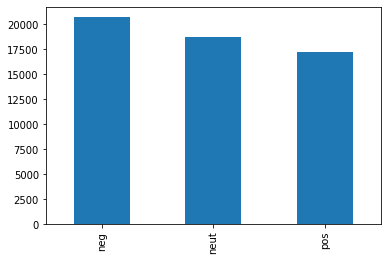

In [12]:
data['Polarity'].value_counts().sort_index().plot.bar()

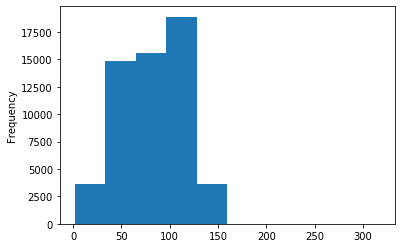

In [13]:
data['Tweet'].str.len().plot.hist()

In [14]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,انترنت_السعوديه_ضعيف نويت اكسر المودم اكثر من...,neg,0
1,الاهلي_الرايد اتمنى نتعاقد مع صانع العاب على ...,neg,0
2,رفع_اسعار_البنزين_والكهرباا حكه يبان معدنه وا...,neut,2
3,اليوم فظيحه تحكيميه قام بها محمد_القرني حكم مب...,neg,0
4,الحكام يخافون على مستقبلهم لايصير فيهم مثل ماص...,neg,0


In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [16]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
#data['clean'] = data['clean'].apply(lambda x: re.sub('([أ-ي]+_[أ-ي]+)', '', x, flags=re.UNICODE))
#data['clean'] = data['clean'].apply(lambda x: re.sub('(_[أ-ي]+)', '', x, flags=re.UNICODE))
data['clean'] = data['clean'].apply(lambda x: re.sub('(_)', ' ', x, flags=re.UNICODE))
#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,انترنت_السعوديه_ضعيف نويت اكسر المودم اكثر من...,neg,0,"[انترنت, السعوديه, ضعيف, نويت, اكسر, المودم, م..."
1,الاهلي_الرايد اتمنى نتعاقد مع صانع العاب على ...,neg,0,"[الاهلي, الرايد, اتمني, نتعاقد, صانع, العاب, م..."
2,رفع_اسعار_البنزين_والكهرباا حكه يبان معدنه وا...,neut,2,"[رفع, اسعار, البنزين, والكهربا, حكه, يبان, معد..."
3,اليوم فظيحه تحكيميه قام بها محمد_القرني حكم مب...,neg,0,"[فظيحه, تحكيميه, محمد, القرني, حكم, مباراه, ال..."
4,الحكام يخافون على مستقبلهم لايصير فيهم مثل ماص...,neg,0,"[الحكام, يخافون, مستقبلهم, لايصير, فيهم, ماصار..."
5,الهلال الهلال_التعاون صفحه وانطوت وتاهلنا لرب...,pos,1,"[الهلال, الهلال, التعاون, صفحه, وانطوت, وتاهلن..."
6,كم نتيجه الهلال_هجر,neut,2,"[نتيجه, الهلال, هجر]"
7,الف مبروووووك الفوووز ي زعماااااا القادم اجمل...,pos,1,"[مبروك, الفوز, زعما, القادم, اجمل, زعيم]"
8,النصر_الاتحاد باذن الله لن تكون مجرد ثلاث نقا...,pos,1,"[النصر, الاتحاد, باذن, اله, مجرد, نقاط, وكفي, ..."
9,معليش اصلا لو ما علقوا الدراسه بكره الخميس نص ...,neut,2,"[معليش, اصلا, علقوا, الدراسه, بكره, الخميس, نص..."


In [17]:
CBOW = Word2Vec.load(str(cbow_path))
CBOWE = CBOW.wv.get_keras_embedding()

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
y = to_categorical(data['Sentiment'].values)

In [19]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,    41,     3,
           31, 18660, 18661,  3459,   134, 18662, 35697, 24258,   651],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     2,    28,   187,
        35698,  1499,  6358,   164,  3994, 15158,  2448,  3178, 24259],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,    14,    16,    15,    19, 35699, 35700, 12976,
         4181,   314, 35701, 18663,   146,   259, 35702, 11265, 24260],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
        24261,  1073,    85,  1236,   158,    33,     2,    28,   451,
         3801,     2,  1089,     3, 15159,   469,     2, 18664,     1],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,   290,
  

In [20]:
X.shape

(56674, 27)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
#Metrics
def plot_data(H, EPOCHS, name='figure.png'):
    # plot the losses
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, EPOCHS), H['acc'],
        label="Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['val_acc'],
        label="Val_Accuracy")
    plt.plot(np.arange(0, EPOCHS), H['loss'],
        label="Loss")
    plt.plot(np.arange(0, EPOCHS), H['val_loss'],
        label="Val_Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy & Loss")
    plt.legend(loc="upper right")
    plt.show()
    if name:
        plt.savefig(name)

In [0]:
#calculation
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# metrics all
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

In [0]:
# hyperparamters
BATCH_SIZE = 32
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2
EPOCHS = 20

In [0]:
#build model
def buildAndRunModel(model, ckpt_path):
    # callbacks
    checkpoints = keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_loss', save_best_only=True, save_weights_only=False)
    
    model.compile(loss='categorical_crossentropy', 
                   optimizer='adam',
                   metrics=metrics,)
    H = model.fit(X_train, y_train, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS,
               callbacks=[checkpoints],)
    return H

In [0]:
def eval_model(model):
    E = model.evaluate(X_test, y_test)
    return list(zip(E, model.metrics_names))

In [0]:

#Stacked-GRU

gru_model_input = layers.Input(shape=(X_train.shape[1],))
embed = CBOWE(gru_model_input)

forw = layers.GRU(100, return_sequences=True, dropout=0.5)(embed)
forw2 = layers.GRU(100, return_sequences=True, dropout=0.5)(forw)
backw = layers.GRU(100, return_sequences=True, go_backwards=True, dropout=0.5)(embed)
backw2 = layers.GRU(100, return_sequences=True, go_backwards=True, dropout=0.5)(backw)
link= layers.Concatenate()([forw2,backw2])

x1 = layers.Flatten()(link)
x2 = layers.Dense(100, activation='relu', name='desne1')(x1)
x3 = layers.Dense(3, activation='softmax', name='desne_output')(x2)

gru_model = keras.models.Model(inputs=gru_model_input, outputs=x3)

In [32]:
gru_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 27)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 27, 100)      33167900    input_3[0][0]                    
__________________________________________________________________________________________________
gru_6 (GRU)                     (None, 27, 100)      60300       embedding_1[2][0]                
__________________________________________________________________________________________________
gru_8 (GRU)                     (None, 27, 100)      60300       embedding_1[2][0]                
____________________________________________________________________________________________

In [33]:
%%time
GRU_H = buildAndRunModel(gru_model, 'gru_ckpt')




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 36271 samples, validate on 9068 samples
Epoch 1/20
36271/36271 [==============================] - 152s 4ms/step - loss: 1.0370 - acc: 0.4602 - precision: 0.5269 - recall: 0.1836 - f1: 0.2469 - val_loss: 0.8723 - val_acc: 0.6010 - val_precision: 0.6467 - val_recall: 0.4527 - val_f1: 0.5398
Epoch 2/20
36271/36271 [==============================] - 149s 4ms/step - loss: 0.9172 - acc: 0.5623 - precision: 0.6078 - recall: 0.4152 - f1: 0.4824 - val_loss: 0.8362 - val_acc: 0.6395 - val_precision: 0.7048 - val_recall: 0.4431 - val_f1: 0.5836
Epoch 3/20
36271/36271 [==============================] - 149s 4ms/step - loss: 0.8760 - acc: 0.5904 - precision: 0.6335 - recall: 0.4862 - f1: 0.5355 - val_loss: 0.8136 - val_acc: 0.6460 - val_precision: 0.6387 - val_recall: 0.6667 - val_f1: 0.6357
Epoch 4/20
36271/36271 [==============================] - 149s 4ms/step - loss: 0.8513 - acc: 0.6123 - 

In [35]:
eval_model(gru_model)

11335/11335 [==============================] - 9s 821us/step


[(0.745552633752053, 'loss'),
 (0.6940449933885845, 'acc'),
 (0.6849185744468983, 'precision'),
 (0.6970934422124168, 'recall'),
 (0.680300283547693, 'f1')]

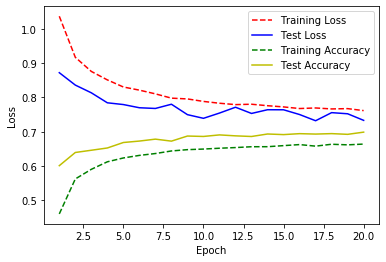

In [36]:
training_loss = GRU_H.history['loss']
test_loss = GRU_H.history['val_loss']
training_acc = GRU_H.history['acc']
test_acc = GRU_H.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.plot(epoch_count, training_acc, 'g--')
plt.plot(epoch_count, test_acc, 'y-')
plt.legend(['Training Loss', 'Test Loss', 'Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();